Ensure latest version of package is installed

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls

drive/  sample_data/  sas-data-efficient-contrastive-learning/


In [2]:
# only run if you need to clone, make sure you have a "cs260d" folder
%cd drive/MyDrive/260d
!git clone https://github.com/sjoshi804/sas-data-efficient-contrastive-learning.git

/content/drive/MyDrive/260d
fatal: destination path 'sas-data-efficient-contrastive-learning' already exists and is not an empty directory.


In [3]:
%cd /content/drive/MyDrive/260d/sas-data-efficient-contrastive-learning

/content/drive/MyDrive/260d/sas-data-efficient-contrastive-learning


In [5]:
# theres gonna be some errors, you need to resolve them
# might need to run this twice for some reason
%pip install -r requirements.txt

In [6]:
%pip install sas-pip/

Processing ./sas-pip
  Preparing metadata (setup.py) ... done
  Created wheel for sas: filename=sas-1.0-py3-none-any.whl size=6289 sha256=7ef669d34e5545fdf5f0515c9f7cf71500a39dcf636ef1cda77f874596f266e7
  Stored in directory: /root/.cache/pip/wheels/a9/76/d2/cd659cce1883dca7b934a1a82cbf9469ff460373cb92d2c6d8
Successfully built sas


Load Data

In [7]:
# restart the kernel if errors appear here
import torchvision
from torchvision import transforms

clean_cifar10 = torchvision.datasets.CIFAR10("/data/cifar10/", transform=transforms.ToTensor(), download=True)
device = "cuda:0"

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /data/cifar10/cifar-10-python.tar.gz to /data/cifar10/


add noise to dataset

In [8]:
import matplotlib.pyplot as plt
import torch

from PIL import Image, ImageFilter

# functions to transfer between pil object and tensor
transform_to_pil = transforms.ToPILImage()
transform_to_tensor = transforms.Compose([transforms.ToTensor()])

def gaussian_blur(x):
  x = transform_to_pil(x)
  im2 = x.filter(ImageFilter.GaussianBlur(radius=4))
  res = transform_to_tensor(im2)

  return res

def gaussian_noise(x):
  a, b, c = x.shape
  d = torch.randn(a, b, c) * .3

  return x + d


def plt2(i, i2):
  """Display two images."""
  fig = plt.figure(figsize=(10, 7))

  # setting values to rows and column variables
  rows = 2
  columns = 1

  fig.add_subplot(rows, columns, 1)

  plt.imshow(i)
  fig.add_subplot(rows, columns, 2)

  plt.imshow(i2)

In [9]:
# choose noisy indices
import random

percent_noisy = .1
noisy_indices = random.sample(range(1, len(clean_cifar10)), int(percent_noisy * len(clean_cifar10)))

In [10]:
class CIFAR10GaussianBlurDataset(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        if index in noisy_indices:
          return gaussian_blur(image), label
        else:
          return image, label

class CIFAR10GaussianNoiseDataset(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        if index in noisy_indices:
          return gaussian_noise(image), label
        else:
          return image, label

In [11]:
cifar10 = CIFAR10GaussianNoiseDataset("/data/cifar10/", transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


Partition into approximate latent classes

In [12]:
from sas.approx_latent_classes import clip_approx
from sas.subset_dataset import SASSubsetDataset

rand_labeled_examples_indices = random.sample(range(len(cifar10)), 500)
rand_labeled_examples_labels = [cifar10[i][1] for i in rand_labeled_examples_indices]

partition = clip_approx(
    img_trainset=cifar10,
    labeled_example_indices=rand_labeled_examples_indices,
    labeled_examples_labels=rand_labeled_examples_labels,
    num_classes=100,
    device=device
)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 113MiB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Train proxy model

In [16]:
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


class ProxyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x





Files already downloaded and verified
Files already downloaded and verified


In [20]:
proxy_model = ProxyModel()

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [19]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = proxy_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.215
[1,  4000] loss: 1.862
[1,  6000] loss: 1.707
[1,  8000] loss: 1.601
[1, 10000] loss: 1.524
[1, 12000] loss: 1.454
[2,  2000] loss: 1.372
[2,  4000] loss: 1.367
[2,  6000] loss: 1.334
[2,  8000] loss: 1.299
[2, 10000] loss: 1.271
[2, 12000] loss: 1.258
Finished Training


In [22]:
PATH = './proxy_models/cifar10_proxy.pth'
torch.save(net.state_dict(), PATH)

### Load proxy model

In [24]:
proxy_model = ProxyModel()
proxy_model.load_state_dict(torch.load("./proxy_models/cifar10_proxy.pth"))

<All keys matched successfully>

##SAS

Determine subset

In [26]:
subset_fraction = 0.2

subset_dataset = SASSubsetDataset(
    dataset=cifar10,
    subset_fraction=subset_fraction,
    num_downstream_classes=100,
    device=device,
    proxy_model=proxy_model,
    approx_latent_class_partition=partition,
    verbose=True
)

Subset Selection:: 100%|██████████| 10/10 [00:22<00:00,  2.30s/it]

Subset Size: 10000
Discarded 40000 examples


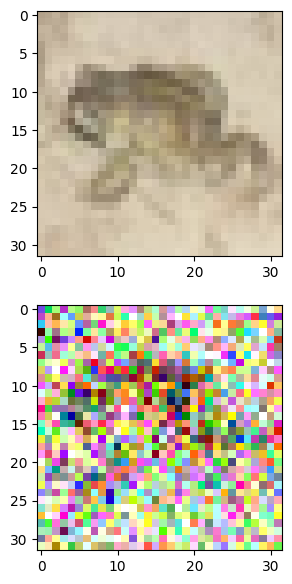

In [27]:
# take a look at the noise we applied
idx = 1

a = clean_cifar10[noisy_indices[idx]][0]
a = a.transpose(0, 2)
a = a.transpose(0, 1)

b = cifar10[noisy_indices[idx]][0]
b = b.transpose(0, 2)
b = b.transpose(0, 1)

plt2(a,b)

Metrics

In [28]:
# This block calculates the success at removing the noisy examples.

# torch.cuda.get_device_name(0)
# %cd sas-data-efficient-contrastive-learning/

print(len(cifar10))

print(len(subset_dataset))
# print(subset_dataset.subset_indices)

print(len(noisy_indices))

inter = set(subset_dataset.subset_indices).intersection(set(noisy_indices))

print(len(inter))

print('SAS subset fraction: ' + str(subset_fraction))

print(len(inter) / len(noisy_indices))

print('Percent of noisy examples removed (should be close to 1, definitely greater than 1-|subset_fraction|):')
print(1 - (len(inter) / len(noisy_indices)))

50000
10000
5000
352
SAS subset fraction: 0.2
0.0704
Percent of noisy examples removed (should be close to 1, definitely greater than 1-|subset_fraction|):
0.9296


Save subset to file

In [ ]:
subset_dataset.save_to_file("cifar100-0.2-sas-indices.pkl")